Corrigir versao de scipy para Inception

In [1]:
pip install scipy==1.3.3

     |████████████████████████████████| 25.2MB 143kB/s 
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.3.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


Importar bibliotecas

In [0]:
from __future__ import division, print_function
from torchvision import datasets, models, transforms
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import zipfile

Montar Google Drive

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Definir constantes

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ZIP_FILE_PATH = './dataset.zip'
DATASET_PATH = './dataset'

INCEPTION = 'inception'
VGG19 = 'vgg-19'
MODEL = INCEPTION # Define o tipo de modelo a ser usado.
IMG_SIZE = {
  INCEPTION: 299,
  VGG19: 224,
}[MODEL]
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 4
NUM_WORKERS = 4

TRAIN = 'train'
VAL = 'val'
TEST = 'test'
PHASES = {
  TRAIN: 'train',
  VAL: 'val',
  TEST: 'test',
}

print(DEVICE)

cuda:0


Limpar diretorio do dataset


In [0]:
shutil.rmtree(DATASET_PATH)

Extrair dataset

In [0]:
zip_file = zipfile.ZipFile(ZIP_FILE_PATH)
zip_file.extractall()
zip_file.close()

Carregar dataset

In [6]:
# Augmentacao de dados para treinamento,
# apenas normalizacao para validacao e teste.
data_transforms = {
  TRAIN: transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
  ]),
  VAL: transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
  ]),
  TEST: transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
  ]),
}
data_sets = {
  phase: datasets.ImageFolder(
    os.path.join(DATASET_PATH, PHASES[phase]),
    data_transforms[phase],
  ) for phase in PHASES
}
data_loaders = {
  phase: torch.utils.data.DataLoader(
    data_sets[phase],
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
  ) for phase in PHASES
}
data_sizes = {
  phase: len(data_sets[phase]) for phase in PHASES
}
class_names = data_sets[TRAIN].classes

print(data_sets)
print(data_loaders)
print(data_sizes)
print(class_names)

{'train': Dataset ImageFolder
    Number of datapoints: 8984
    Root location: ./dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 1492
    Root location: ./dataset/val
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 1492
    Root location: ./dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=PIL.Image.BILINEAR)
               ToTensor()
        

Helper functions

In [0]:
# Exibe uma imagem a partir de um Tensor.
def imshow(data):
  mean = np.array(NORMALIZE_MEAN)
  std = np.array(NORMALIZE_STD)
  image = data.numpy().transpose((1, 2, 0))
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)

In [0]:
# Treina o modelo e retorna o modelo treinado.
def train_model(model_type, model, optimizer, criterion, num_epochs = 25):
  start_time = time.time()

  num_epochs_without_improvement = 0

  best_acc = 0.0
  best_model = copy.deepcopy(model.state_dict())
  torch.save(best_model, 'model.pth')

  for epoch in range(num_epochs):
    print('Epoch {}/{} ...'.format(epoch + 1, num_epochs))

    for phase in PHASES:
      if phase == TRAIN:
        model.train()
      elif phase == VAL:
        model.eval()
      else:
        continue

      running_loss = 0.0
      running_corrects = 0

      for data, labels in data_loaders[phase]:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == TRAIN):
          outputs = model(data)
          if phase == TRAIN and model_type == INCEPTION:
            outputs = outputs.logits
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == TRAIN:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / data_sizes[phase]
      epoch_acc = running_corrects.double() / data_sizes[phase]

      print('{} => Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == VAL:
        if epoch_acc > best_acc:
          num_epochs_without_improvement = 0
          best_acc = epoch_acc
          best_model = copy.deepcopy(model.state_dict())
          torch.save(best_model, 'model.pth')
        else:
          num_epochs_without_improvement += 1
    
    if num_epochs_without_improvement == 50:
      print('Exiting early...')
      break

  elapsed_time = time.time() - start_time
  print('Took {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))
  print('Best Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model)

  return model

In [0]:
# Visualiza algumas predicoes do modelo.
def visualize_model(model, num_images = 6):
  was_training = model.training

  model.eval()

  fig = plt.figure()
  images_so_far = 0

  with torch.no_grad():
    for i, (data, labels) in enumerate(data_loaders[TEST]):
      data = data.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = model(data)
      _, preds = torch.max(outputs, 1)

      for j in range(data.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
        imshow(data.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode = was_training)
          return

    model.train(mode = was_training)

In [0]:
# Testa o modelo.
def test_model(model, criterion):
  was_training = model.training

  model.eval()

  running_loss = 0.0
  running_corrects = 0

  with torch.no_grad():
    for data, labels in data_loaders[TEST]:
      data = data.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * data.size(0)
      running_corrects += torch.sum(preds == labels.data)

  loss = running_loss / data_sizes[TEST]
  acc = running_corrects.double() / data_sizes[TEST]

  print('Loss: {:4f}, Acc: {:4f}'.format(loss, acc))

  model.train(mode = was_training)

Exibir amostra do dataset

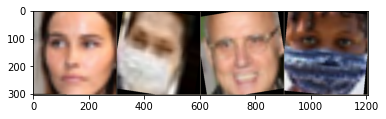

In [11]:
data, labels = next(iter(data_loaders[TRAIN]))
grid = torchvision.utils.make_grid(data)
imshow(grid)

Definir modelo

In [16]:
if MODEL == INCEPTION:
  model = models.inception_v3(pretrained = True, progress = True)

  print(model.fc)

  for param in model.parameters():
    param.requires_grad = False
  
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, len(class_names))
  model = model.to(DEVICE)
  optimizer = optim.SGD(model.fc.parameters(), lr = 0.001, momentum = 0.9)
elif MODEL == VGG19:
  model = models.vgg19(pretrained = True, progress = True)

  print(model.classifier[6])

  for param in model.parameters():
    param.requires_grad = False
  
  num_features = model.classifier[6].in_features
  model.classifier[6] = nn.Linear(num_features, len(class_names))
  model = model.to(DEVICE)
  optimizer = optim.SGD(model.classifier[6].parameters(), lr = 0.001, momentum = 0.9)
else:
  print('ERRO: Nenhum tipo de modelo definido!')

criterion = nn.CrossEntropyLoss()

print(model)

Linear(in_features=2048, out_features=1000, bias=True)
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): B

Treinar modelo

In [17]:
model = train_model(MODEL, model, optimizer, criterion)

Epoch 1/25 ...
train => Loss: 0.4843, Acc: 0.7777
val => Loss: 0.3477, Acc: 0.8458
Epoch 2/25 ...
train => Loss: 0.4682, Acc: 0.8038
val => Loss: 0.2949, Acc: 0.8727
Epoch 3/25 ...
train => Loss: 0.4837, Acc: 0.8020
val => Loss: 0.2188, Acc: 0.9303
Epoch 4/25 ...
train => Loss: 0.4684, Acc: 0.8088
val => Loss: 0.2142, Acc: 0.9283
Epoch 5/25 ...
train => Loss: 0.5015, Acc: 0.8015
val => Loss: 0.2524, Acc: 0.8968
Epoch 6/25 ...
train => Loss: 0.4965, Acc: 0.8021
val => Loss: 0.2148, Acc: 0.9196
Epoch 7/25 ...
train => Loss: 0.4960, Acc: 0.8018
val => Loss: 0.2067, Acc: 0.9296
Epoch 8/25 ...
train => Loss: 0.4781, Acc: 0.8083
val => Loss: 0.2058, Acc: 0.9249
Epoch 9/25 ...
train => Loss: 0.4786, Acc: 0.8132
val => Loss: 0.2041, Acc: 0.9182
Epoch 10/25 ...
train => Loss: 0.5388, Acc: 0.7901
val => Loss: 0.2251, Acc: 0.9135
Epoch 11/25 ...
train => Loss: 0.4930, Acc: 0.8057
val => Loss: 0.2275, Acc: 0.9182
Epoch 12/25 ...
train => Loss: 0.4944, Acc: 0.8045
val => Loss: 0.4300, Acc: 0.8251
E

Visualizar modelo

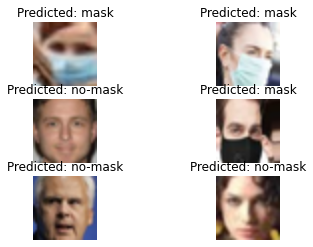

In [20]:
visualize_model(model)

Testar modelo

In [21]:
model.load_state_dict(torch.load('model.pth'))
test_model(model, criterion)

Loss: 0.232413, Acc: 0.922922


Salvar modelo para CPU

In [0]:
model = model.cpu()
torch.save(model.state_dict(), 'model-cpu.pth')

Salvar no Google Drive

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/model-inception.pth')